# Data Set Up

In [1]:
!pip install pyathena

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install awswrangler

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 211 kB 1.4 MB/s            
     |████████████████████████████████| 94 kB 10.2 MB/s             
     |████████████████████████████████| 43 kB 5.7 MB/s              
     |████████████████████████████████| 207 kB 113.8 MB/s            
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import intersect1d
from datetime import datetime
from pyathena import connect
import boto3
import awswrangler as wr

In [4]:
from ethereum import (
    timestamp_to_datetime,
    EthereumData
)
from utils import (
    latest,
    lead_lag,
    add_latest_avail_block,
    lagged_block_data
)

## Blocks

In [5]:
blocks_df = wr.s3.read_csv(path="s3://sagemaker-w210-eth/raw_data/infuria/blocks")

In [6]:
blocks_df.head()

,number,hash,parent_hash,nonce,sha3_uncles,logs_bloom,transactions_root,state_root,receipts_root,miner,difficulty,total_difficulty,size,extra_data,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas
0,12962018,0x93288d45fd0daac2605174fc6d14d27a1f18ed6d72ae...,0x9c42cc01eb5564709c476eff08065a67fc8e479e996c...,0xf1828e43fadfc703,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x60af99ca65d7000f80980c1cef011a3b585619005110...,0xa6d240b3a7409a4f197e347d5dbed9159802e4787b82...,0x6459e84f5309663bb565625ed662809c0233889631c8...,0x0cadca37374ac1442ab84af32b4d1dc0e90837b1fc71...,0x829bd824b016326a401d083b33d092293333a830,7604452341876898,28471525393295665706633,55433,0xe4b883e5bda9e7a59ee4bb99e9b1bc020321,15000000,14994306,1628126126,160,NaN
1,12962019,0xeb13f4f4bc463d6ff438df7ea04074a064ca95b474cc...,0x93288d45fd0daac2605174fc6d14d27a1f18ed6d72ae...,0xa4bfd2e7099b4a6b,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x532383a629274b7190ccc2d0aa02986d54e296d49823...,0x9b9701c0c94d550770390ec857e85e650874ec32cd79...,0xb75212595e6aedf34bae4f08d1dddd3a34a933f0cb09...,0x95cda15e5b562751ce34c3760b5ebedae43fc60fe9d5...,0x8595dd9e0438640b5e1254f9df579ac12a86865f,7604589780830370,28471532997885446537003,79403,0x657a696c2e6d65,14985353,14969945,1628126136,217,NaN
2,12962020,0x50ded5bb455b2bc00392dd36dcfff3d3019eb9517478...,0xeb13f4f4bc463d6ff438df7ea04074a064ca95b474cc...,0xe21691d992c44366,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x30f7606e59608213d0e6f610b860da97c90291082a18...,0x6e39ad0229b49c1c0793d4ac9f84ee3cfafde05f31ca...,0xb533fcc03912aad33abe748bd627bd1ca1233284a462...,0xdcabba7c1257c64d0ed6d845048727a3291aed33f358...,0x7f101fe45e6649a6fb8f3f8b43ed03d353f2b90c,7601014041179921,28471540598899487716924,69949,0x466c6578706f6f6c2f53302f55532d45617374202d20...,14970720,14964505,1628126157,155,NaN
3,12962021,0xc3e9e7c41845ae59c14e7b278ab9a2d4c56368761d3c...,0x50ded5bb455b2bc00392dd36dcfff3d3019eb9517478...,0x130800068dfdf6ed,0x34db8d1d8cd5772d238ecfa7e41114456c3f188235b9...,0xe0b1082ad3da6c93ca8e20eda8619e514f6651111166...,0x463fa688671b03a26f1812b161dab03b7ba55d4f2336...,0xd9e98811a4b7d7a22912ded685ff1a1537eda9729509...,0xe654f88bcd7177c2e5457910a848513dd475920897db...,0x09ab1303d3ccaf5f018cd511146b07a240c70294,7601151480133393,28471548200050967850317,92704,0x6d696e6572616c6c2e696f,14956102,14944125,1628126167,195,NaN
4,12962022,0x662aac52ee02b41ac3f3de32382eff0c5d1a4eeb31d2...,0xc3e9e7c41845ae59c14e7b278ab9a2d4c56368761d3c...,0x979e4f65cdc6a89d,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x76a1f1b641489b8d5090e6dfa2781725a2c61333f898...,0x8371509cd79d207d83603fec4397472abc9deb1f8c82...,0xacc983062bb1a54aded29c48652d5def40c47987f424...,0xd6924c31610c313db53b63a03554b8e124d1b6a3195e...,0x5a0b54d5dc17e0aadc383d2db43b0a0d3e029c4c,7597577419340707,28471555797628387191024,65855,0xd883010a06846765746888676f312e31362e36856c69...,14963388,14943452,1628126200,178,NaN


In [7]:
print("Blocks shape:", blocks_df.shape)
print("Minimum block number:", blocks_df.number.min())
print("Maximum block number:", blocks_df.number.max())

Blocks shape: (566141, 19)
Minimum block number: 12961718
Maximum block number: 13527858


In [8]:
cols = [
    'number', 'difficulty', 'total_difficulty', 'size', 'gas_limit', 
    'gas_used', 'timestamp', 'transaction_count', 'base_fee_per_gas'
]

blocks_df = blocks_df[cols]


In [9]:
print("# of unique blocks:", len(pd.unique(blocks_df.number)))

# of unique blocks: 566141


In [10]:
blocks_df.head()

,number,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas
0,12962018,7604452341876898,28471525393295665706633,55433,15000000,14994306,1628126126,160,NaN
1,12962019,7604589780830370,28471532997885446537003,79403,14985353,14969945,1628126136,217,NaN
2,12962020,7601014041179921,28471540598899487716924,69949,14970720,14964505,1628126157,155,NaN
3,12962021,7601151480133393,28471548200050967850317,92704,14956102,14944125,1628126167,195,NaN
4,12962022,7597577419340707,28471555797628387191024,65855,14963388,14943452,1628126200,178,NaN


In [11]:
# set index and add readable timestamp
blocks_df = blocks_df.set_index('number')
blocks_df['timestamp_2'] = pd.to_datetime(blocks_df['timestamp'], unit='s')

In [12]:
blocks_df = blocks_df.sort_index()

In [13]:
blocks_df.head()

,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas,timestamp_2
number,,,,,,,,,
12961718,7774193366499997,28469210465037599682985,73653,14970676,14957821,1628121604,152,NaN,2021-08-05 00:00:04
12961719,7778126798308205,28469218243164397991190,103790,14985294,14975998,1628121607,235,NaN,2021-08-05 00:00:07
12961720,7766870496834469,28469226010034894825659,101080,14999927,14981552,1628121647,196,NaN,2021-08-05 00:00:47
12961721,7770800353022723,28469233780835247848382,68027,15000000,14987640,1628121663,194,NaN,2021-08-05 00:01:03
12961722,7767143455866321,28469241547978703714703,543,15000000,0,1628121685,0,NaN,2021-08-05 00:01:25


In [14]:
blocks_df['base_fee_per_gas'].describe()

count    5.628590e+05
mean     8.389799e+10
std      7.564743e+10
min      1.000000e+09
25%      4.832533e+10
50%      6.923107e+10
75%      9.901271e+10
max      3.941920e+12
Name: base_fee_per_gas, dtype: float64

#### Get rid of empty blocks

In [15]:
print("Length of all blocks:", len(blocks_df))
print("Length of blocks:", len(blocks_df[(blocks_df.transaction_count>0)]))
print("Length of blocks with transaction count and gas used > 0:", len(blocks_df[(blocks_df.transaction_count>0) & (blocks_df.gas_used>0)]))
print("Length of blocks with transaction count> 0 and base_fee_per_gas not NA:", len(blocks_df[(blocks_df.transaction_count>0) \
                                                                                               & (blocks_df.base_fee_per_gas.isna()==False)]))
print("Length of blocks with transaction count> 0 and base_fee_per_gas not null:", len(blocks_df[(blocks_df.transaction_count>0) \
                                                                                                 & (blocks_df.base_fee_per_gas.isnull()==False)]))


Length of all blocks: 566141
Length of blocks: 556937
Length of blocks with transaction count and gas used > 0: 556937
Length of blocks with transaction count> 0 and base_fee_per_gas not NA: 553701
Length of blocks with transaction count> 0 and base_fee_per_gas not null: 553701


In [16]:
blocks_df[(blocks_df.transaction_count>0) & (blocks_df.base_fee_per_gas.isna()==False)]['size'].describe(percentiles=[.01, .05, .10])

count    5.537010e+05
mean     7.848288e+04
std      5.735261e+04
min      6.450000e+02
1%       2.532000e+03
5%       7.274000e+03
10%      1.244300e+04
50%      6.756700e+04
max      1.457148e+06
Name: size, dtype: float64

In [17]:
blocks_df[(blocks_df['size']>645)].sort_values(by='size')

,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas,timestamp_2
number,,,,,,,,,
12966286,7510304652923402,28504171605039036664811,647,27918577,21000,1628184475,1,2.899581e+11,2021-08-05 17:27:55
13076297,7941442504924537,29358293326877363563510,647,30117180,21000,1629651424,1,8.259192e+10,2021-08-22 16:57:04
13289787,8926291982138655,31212365072593406972060,648,30000000,21000,1632504249,1,6.448137e+10,2021-09-24 17:24:09
12978690,7519710842566709,28596839127932254661813,648,30058506,21000,1628349275,1,5.078646e+10,2021-08-07 15:14:35
13168211,8705853904688391,30124311908394087602088,650,30087972,21000,1630878283,1,1.612576e+11,2021-09-05 21:44:43
...,...,...,...,...,...,...,...,...,...
13406291,9881198656769968,32301416281726083451430,921585,30000000,29989351,1634077112,412,2.207057e+11,2021-10-12 22:18:32
13406290,9876341864480585,32301406400527426681462,926212,30029295,30008596,1634077107,395,1.962129e+11,2021-10-12 22:18:27
13406324,9834047595011648,32301740659840471112061,949582,30058504,30052796,1634077632,436,1.286141e+11,2021-10-12 22:27:12


In [18]:
print("Length of blocks with transaction count> 0 and base_fee_per_gas not null:", len(blocks_df[(blocks_df.transaction_count>0) \
                                                                                                 & (blocks_df.base_fee_per_gas.isnull()==False)]))


Length of blocks with transaction count> 0 and base_fee_per_gas not null: 553701


#### Create percent changes in variables

In [19]:
cols = ['difficulty', 'total_difficulty', 'size', 'gas_limit', 'base_fee_per_gas']
for c in cols:
    print(c, blocks_df[c].dtype)

difficulty int64
total_difficulty object
size int64
gas_limit int64
base_fee_per_gas float64


In [20]:
# Change difficulty to float to calculate change in difficulty
blocks_df['total_difficulty'] = blocks_df['total_difficulty'].astype(float)

In [21]:
cols = ['difficulty', 'total_difficulty', 'size', 'gas_limit', 'base_fee_per_gas']
for col in cols:
    blocks_df[col+'_pct_chg'] = blocks_df[col]/blocks_df[col].shift(1)-1

In [22]:
blocks_df.tail()

,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas,timestamp_2,difficulty_pct_chg,total_difficulty_pct_chg,size_pct_chg,gas_limit_pct_chg,base_fee_per_gas_pct_chg
number,,,,,,,,,,,,,,
13527854,10142061783382444,3.349723e+22,59466,30029295,14081332,1635724692,185,1.721710e+11,2021-10-31 23:58:12,0.000495,3.027732e-07,3.496484,0.000976,-0.098995
13527855,10142130502859180,3.349724e+22,113946,30058619,30037769,1635724708,407,1.708332e+11,2021-10-31 23:58:28,0.000007,3.027752e-07,0.916154,0.000977,-0.007770
13527856,10127342585857119,3.349725e+22,101346,30029266,20028596,1635724748,186,1.921577e+11,2021-10-31 23:59:08,-0.001458,3.023336e-07,-0.110579,-0.000977,0.124827
13527857,10127411305333855,3.349726e+22,12068,30000000,2550891,1635724758,30,2.001788e+11,2021-10-31 23:59:18,0.000007,3.023356e-07,-0.880923,-0.000975,0.041742
13527858,10132425049862023,3.349727e+22,132704,29980831,29719237,1635724760,408,1.794118e+11,2021-10-31 23:59:20,0.000495,3.024852e-07,9.996354,-0.000639,-0.103743


<AxesSubplot:xlabel='number'>

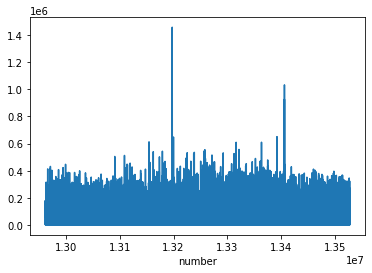

In [23]:
blocks_df['size'].plot()

In [24]:
print(blocks_df['size'].min())
print(blocks_df['size'].max())

520
1457148


In [25]:
blocks_df['size'].describe(percentiles=[.01, .05, .10, .5, .9, .95, .99])

count    5.661410e+05
mean     7.718583e+04
std      5.759466e+04
min      5.200000e+02
1%       5.460000e+02
5%       5.587000e+03
10%      1.097300e+04
50%      6.619700e+04
90%      1.556650e+05
95%      1.781670e+05
99%      2.285856e+05
max      1.457148e+06
Name: size, dtype: float64

In [26]:
blocks_df[(blocks_df.transaction_count>0) & (blocks_df.gas_used>0)]['size'].describe(percentiles=[.01, .05, .10, .5, .9, .95, .99])

count    5.569370e+05
mean     7.845211e+04
std      5.721307e+04
min      6.400000e+02
1%       2.537000e+03
5%       7.304000e+03
10%      1.250500e+04
50%      6.765800e+04
90%      1.562404e+05
95%      1.787132e+05
99%      2.292259e+05
max      1.457148e+06
Name: size, dtype: float64

In [27]:
blocks_df[(blocks_df.transaction_count>0) & (blocks_df.gas_used>0)].sort_values(by=['size'])

,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas,timestamp_2,difficulty_pct_chg,total_difficulty_pct_chg,size_pct_chg,gas_limit_pct_chg,base_fee_per_gas_pct_chg
number,,,,,,,,,,,,,,
12962740,7686582481082049,2.847710e+22,640,15000000,14717667,1628135866,1,NaN,2021-08-05 03:57:46,-0.000959,2.699216e-07,-0.990835,0.000000,NaN
12963936,7491198836736213,2.848626e+22,640,15000000,14717667,1628152774,1,NaN,2021-08-05 08:39:34,-0.003400,2.629759e-07,-0.991152,0.000490,NaN
12962758,7700305493709583,2.847724e+22,640,14999986,14717667,1628136068,1,NaN,2021-08-05 04:01:08,0.000018,2.704022e-07,-0.992018,0.000976,NaN
13128919,8356837811943998,2.978977e+22,645,30000000,21000,1630353930,1,2.259305e+12,2021-08-30 20:05:30,-0.000488,2.805272e-07,-0.927512,0.000000,0.033774
12966286,7510304652923402,2.850417e+22,647,27918577,21000,1628184475,1,2.899581e+11,2021-08-05 17:27:55,0.000488,2.634810e-07,-0.916559,0.000977,-0.069691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13406291,9881198656769968,3.230142e+22,921585,30000000,29989351,1634077112,412,2.207057e+11,2021-10-12 22:18:32,0.000492,3.059061e-07,-0.004996,-0.000976,0.124828
13406290,9876341864480585,3.230141e+22,926212,30029295,30008596,1634077107,395,1.962129e+11,2021-10-12 22:18:27,-0.000485,3.057559e-07,0.078552,0.000976,0.124968
13406324,9834047595011648,3.230174e+22,949582,30058504,30052796,1634077632,436,1.286141e+11,2021-10-12 22:27:12,0.000492,3.044434e-07,13.906160,-0.000977,-0.057071


In [28]:
blocks_df = blocks_df[(blocks_df.transaction_count>0) & (blocks_df.gas_used>0) & (blocks_df.base_fee_per_gas.isnull()==False)]

In [29]:
print("# of unique blocks:", len(pd.unique(blocks_df.reset_index().number)))

# of unique blocks: 553701


In [30]:
len(blocks_df)

553701

#### Create smoothed size since it is so volatile

In [31]:
blocks_df['smoothed_size_5'] = blocks_df['size'].rolling(5).mean()

#### Calculate lagged variables from blocks to join to PIT

In [32]:
cols = ['difficulty', 'total_difficulty', 'size', 'gas_limit', 'base_fee_per_gas', 'smoothed_size_5']
for col in cols:
    print(col, blocks_df[col].dtype)

difficulty int64
total_difficulty float64
size int64
gas_limit int64
base_fee_per_gas float64
smoothed_size_5 float64


In [33]:
blocks_df['total_difficulty'] = blocks_df['total_difficulty'].astype(float)

In [34]:
cols = ['difficulty', 'total_difficulty', 'size', 'gas_limit', 'base_fee_per_gas', 'smoothed_size_5']
for col in cols:
    # Last 5 blocks
    blocks_df[col+'_pct_chg_last_5'] = blocks_df[col]/blocks_df[col].shift(5)-1
    # 25 blocks ago to 5 blocks ago percentage changes
    blocks_df[col+'_pct_chg_last_25_to_5'] = blocks_df[col].shift(5)/blocks_df[col].shift(25)-1
    # 50 blocks ago to 5 blocks ago percentage changes
    blocks_df[col+'_pct_chg_last_50_to_5'] = blocks_df[col].shift(5)/blocks_df[col].shift(50)-1
    # 100 blocks ago to 5 blocks ago percentage changes
    blocks_df[col+'_pct_chg_last_100_to_5'] = blocks_df[col].shift(5)/blocks_df[col].shift(100)-1

In [35]:
blocks_df.head()

,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas,timestamp_2,difficulty_pct_chg,...,gas_limit_pct_chg_last_50_to_5,gas_limit_pct_chg_last_100_to_5,base_fee_per_gas_pct_chg_last_5,base_fee_per_gas_pct_chg_last_25_to_5,base_fee_per_gas_pct_chg_last_50_to_5,base_fee_per_gas_pct_chg_last_100_to_5,smoothed_size_5_pct_chg_last_5,smoothed_size_5_pct_chg_last_25_to_5,smoothed_size_5_pct_chg_last_50_to_5,smoothed_size_5_pct_chg_last_100_to_5
number,,,,,,,,,,,,,,,,,,,,,
12965000,7742494561645080,2.849441e+22,137049,30029122,30025257,1628166822,259,1.000000e+09,2021-08-05 12:33:42,1.386817e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12965001,7742495635386904,2.849442e+22,158678,29999798,29985144,1628166835,257,1.124968e+09,2021-08-05 12:33:55,1.386816e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12965002,7738716193681762,2.849442e+22,96685,29970503,29950343,1628166854,321,1.265451e+09,2021-08-05 12:34:14,-4.881426e-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12965003,7742495937440032,2.849443e+22,86936,29941236,29933895,1628166857,265,1.423420e+09,2021-08-05 12:34:17,4.884200e-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12965004,7742497011181856,2.849444e+22,89206,29911998,29895283,1628166868,280,1.601260e+09,2021-08-05 12:34:28,1.386816e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
blocks_df.describe()

,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas,difficulty_pct_chg,total_difficulty_pct_chg,...,gas_limit_pct_chg_last_50_to_5,gas_limit_pct_chg_last_100_to_5,base_fee_per_gas_pct_chg_last_5,base_fee_per_gas_pct_chg_last_25_to_5,base_fee_per_gas_pct_chg_last_50_to_5,base_fee_per_gas_pct_chg_last_100_to_5,smoothed_size_5_pct_chg_last_5,smoothed_size_5_pct_chg_last_25_to_5,smoothed_size_5_pct_chg_last_50_to_5,smoothed_size_5_pct_chg_last_100_to_5
count,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,553701.000000,5.537010e+05,553701.000000,5.537010e+05,...,553651.000000,553601.000000,553696.000000,553676.000000,553651.000000,553601.000000,553692.000000,553672.000000,553647.000000,553597.000000
mean,8.887769e+15,3.087335e+22,7.848288e+04,3.001038e+07,1.570156e+07,1.631931e+09,191.923693,8.391257e+10,0.000002,2.873739e-07,...,0.000002,0.000004,0.012125,0.031613,0.061971,0.086735,0.092125,0.088190,0.103078,0.118182
std,7.744856e+14,1.450218e+21,5.735261e+04,1.167284e+05,1.021422e+07,2.181715e+06,142.233560,7.562234e+10,0.000702,1.280310e-08,...,0.001617,0.001706,0.161417,0.338931,0.764655,0.914771,0.481576,0.487433,0.601250,0.733246
min,7.213602e+15,2.849441e+22,6.450000e+02,2.744222e+07,2.100000e+04,1.628167e+09,1.000000,1.000000e+09,-0.008297,2.519518e-07,...,-0.023185,-0.030809,-0.501010,-0.875538,-0.953787,-0.966653,-0.959590,-0.958469,-0.963633,-0.961527
25%,8.238066e+15,2.959666e+22,2.964800e+04,3.000000e+07,6.411621e+06,1.630040e+09,77.000000,4.832476e+10,-0.000482,2.787435e-07,...,-0.000976,-0.000976,-0.100492,-0.131409,-0.150096,-0.167539,-0.242634,-0.229829,-0.235309,-0.239151
50%,8.968790e+15,3.081571e+22,6.756700e+04,3.000000e+07,1.416338e+07,1.631920e+09,164.000000,6.924509e+10,0.000007,2.895568e-07,...,0.000000,0.000000,-0.010770,-0.007819,-0.008893,-0.008292,0.002616,0.001647,-0.001092,-0.002566
75%,9.498624e+15,3.211797e+22,1.200710e+05,3.002930e+07,2.673512e+07,1.633817e+09,286.000000,9.905390e+10,0.000489,2.967773e-07,...,0.000976,0.000976,0.099301,0.138022,0.160293,0.184461,0.323770,0.301093,0.305609,0.310624
max,1.066084e+16,3.349727e+22,1.457148e+06,3.038299e+07,3.029293e+07,1.635725e+09,1431.000000,3.941920e+12,0.000984,3.193828e-07,...,0.027697,0.024666,0.801837,9.533298,51.133279,56.294291,11.770659,16.124391,36.815108,31.994244


## Transactions

In [37]:
# Old way

# transactions_df_1 = pd.read_csv(r'data/transactions_small/12961718_13136426.csv')
# transactions_df_2 = pd.read_csv(r'data/transactions_small/13136427_13330089.csv')
# transactions_df_3 = pd.read_csv(r'data/transactions_small/13330090_13527858.csv')

# print("transactions_df_1 shape:", transactions_df_1.shape)
# print("transactions_df_2 shape:", transactions_df_2.shape)
# print("transactions_df_3 shape:", transactions_df_3.shape)

# transactions_df = pd.concat([transactions_df_1, transactions_df_2, transactions_df_3], ignore_index=True)
# transactions_df.shape

# transactions_df['block_timestamp_2'] = pd.to_datetime(transactions_df['block_timestamp'], unit='s')

# cols = [
#     'transaction_id', 'block_number', 'transaction_index', 'value', 
#     'gas', 'gas_price', 'block_timestamp', 'max_fee_per_gas', 'max_priority_fee_per_gas',
#     'transaction_type'
# ]
# transactions_df = transactions_df[cols]

# print("Minimum block number:", transactions_df.block_number.min())
# print("Maximum block number:", transactions_df.block_number.max())

In [38]:
transactions_df = pd.read_csv(r'data/transactions_small.csv')
transactions_df.shape

(106896300, 10)

In [39]:
transactions_df.head()

,transaction_id,block_number,transaction_index,value,gas,gas_price,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,block_timestamp
0,133302900000000000,13330290,0,300000000000000000,611894,74759089945,7.500000e+10,1.500000e+09,2,1633049163
1,133302900000000001,13330290,1,0,184981,74759089945,1.770000e+11,1.500000e+09,2,1633049163
2,133302900000000002,13330290,2,0,278299,74259089945,7.500000e+10,1.000000e+09,2,1633049163
3,133302900000000003,13330290,3,74423577302830566,21000,1613659229046,NaN,NaN,0,1633049163
4,133302900000000004,13330290,4,9368049882777163,21000,111116168767,1.111162e+11,1.111162e+11,2,1633049163


In [40]:
print("Minimum block number:", transactions_df.block_number.min())
print("Maximum block number:", transactions_df.block_number.max())

Minimum block number: 12961718
Maximum block number: 13527858


In [41]:
print("# of unique blocks:", len(pd.unique(transactions_df.block_number)))

# of unique blocks: 556937


In [42]:
transactions_df.describe()

,transaction_id,block_number,transaction_index,gas,gas_price,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,block_timestamp
count,1.068963e+08,1.068963e+08,1.068963e+08,1.068963e+08,1.068963e+08,5.248754e+07,5.248754e+07,1.068963e+08,1.068963e+08
mean,1.324922e+17,1.324922e+07,1.479638e+02,1.734908e+05,9.889336e+10,1.595239e+11,1.693126e+10,9.823450e-01,1.631970e+09
std,1.655212e+15,1.655212e+05,1.314379e+02,3.818745e+05,5.156944e+12,1.598618e+13,7.357534e+12,9.996853e-01,2.221511e+06
min,1.296172e+17,1.296172e+07,0.000000e+00,2.100000e+04,0.000000e+00,1.423420e+09,0.000000e+00,0.000000e+00,1.628122e+09
25%,1.310515e+17,1.310514e+07,5.100000e+01,3.650700e+04,5.496497e+10,7.800000e+10,1.500000e+09,0.000000e+00,1.630036e+09
50%,1.324835e+17,1.324835e+07,1.170000e+02,9.926200e+04,7.802267e+10,1.114272e+11,1.940000e+09,0.000000e+00,1.631951e+09
75%,1.339462e+17,1.339462e+07,2.130000e+02,2.260900e+05,1.139259e+11,1.655751e+11,3.000000e+09,2.000000e+00,1.633919e+09
max,1.352786e+17,1.352786e+07,1.430000e+03,3.017625e+07,5.324367e+16,1.157740e+17,5.324361e+16,2.000000e+00,1.635725e+09


In [43]:
transactions_df['max_priority_fee_per_gas'].isnull().sum()

54408756

In [44]:
len(transactions_df[transactions_df['max_priority_fee_per_gas']==0])

3222651

In [45]:
len(transactions_df[transactions_df['max_priority_fee_per_gas'].isnull()])

54408756

In [46]:
len(transactions_df[transactions_df['max_priority_fee_per_gas'].isnull()]['block_number'].unique())

555757

In [57]:
a = transactions_df[['block_number','max_priority_fee_per_gas']].groupby('block_number').mean()
a

,max_priority_fee_per_gas
block_number,
12961718,NaN
12961719,NaN
12961720,NaN
12961721,NaN
12961723,NaN
...,...
13527854,1.636708e+10
13527855,2.233492e+10
13527856,7.948101e+09


In [58]:
a1 = a[a.max_priority_fee_per_gas.isnull()]
a1

,max_priority_fee_per_gas
block_number,
12961718,NaN
12961719,NaN
12961720,NaN
12961721,NaN
12961723,NaN
...,...
13523474,NaN
13524519,NaN
13525234,NaN


In [59]:
transactions_df[transactions_df.max_priority_fee_per_gas==0]

,transaction_id,block_number,transaction_index,value,gas,gas_price,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,block_timestamp
474,133302930000000000,13330293,0,0,1200000,77174821201,1.054834e+11,0.0,2,1633049191
475,133302930000000001,13330293,1,0,2000000,77174821201,7.717482e+10,0.0,2,1633049191
672,133302950000000002,13330295,2,0,500000,79473026748,8.014487e+10,0.0,2,1633049208
679,133302950000000009,13330295,9,0,1200000,79473026748,9.767384e+10,0.0,2,1633049208
2473,133302970000000000,13330297,0,0,1200000,100572250935,1.653724e+11,0.0,2,1633049246
...,...,...,...,...,...,...,...,...,...,...
106893888,133299770000000000,13329977,0,0,1200000,119550588009,1.747967e+11,0.0,2,1633044725
106893889,133299770000000001,13329977,1,0,400000,119550588009,1.587617e+11,0.0,2,1633044725
106894132,133299800000000002,13329980,2,158920616381841839,250000,113827451878,2.310697e+11,0.0,2,1633044738
106895002,133299940000000000,13329994,0,0,2000000,590607877205,5.906079e+11,0.0,2,1633045011


In [60]:
transactions_df['max_priority_fee_per_gas'] = transactions_df['max_priority_fee_per_gas'].fillna(0)

In [61]:
len(transactions_df[transactions_df['max_priority_fee_per_gas'].isnull()])

0

## Receipts

In [47]:
receipts_df = pd.read_csv(r'data/receipts_small.csv')
receipts_df.shape

(109234686, 7)

In [48]:
receipts_df.head()

,transaction_id,transaction_index,block_number,receipt_cumulative_gas_used,receipt_gas_used,receipt_status,receipt_effective_gas_price
0,130970770000000042,42,13097077,20269277,615110,1,699757885383
1,130792690000000094,94,13079269,4909942,105802,1,62815025192
2,130989030000000240,240,13098903,16465005,218423,1,69615073997
3,131641020000000106,106,13164102,7507934,21000,1,157010799148
4,131636110000000098,98,13163611,5929557,21000,1,99382274301


In [49]:
print("Minimum block number:", receipts_df.block_number.min())
print("Maximum block number:", receipts_df.block_number.max())

Minimum block number: 12961719
Maximum block number: 13538797


In [50]:
print("# of unique blocks:", len(pd.unique(receipts_df.block_number)))

# of unique blocks: 567717


In [51]:
receipts_df.describe()

,transaction_id,transaction_index,block_number,receipt_cumulative_gas_used,receipt_gas_used,receipt_status,receipt_effective_gas_price
count,1.092347e+08,1.092347e+08,1.092347e+08,1.092347e+08,1.092347e+08,1.092347e+08,1.092347e+08
mean,1.325531e+17,1.482895e+02,1.325531e+07,1.004188e+07,8.158009e+04,9.638879e-01,1.004365e+11
std,1.688291e+15,1.315752e+02,1.688291e+05,7.982465e+06,1.676503e+05,1.865691e-01,5.101533e+12
min,1.296172e+17,0.000000e+00,1.296172e+07,1.926000e+04,1.352400e+04,0.000000e+00,0.000000e+00
25%,1.310831e+17,5.100000e+01,1.310831e+07,3.310911e+06,2.100000e+04,1.000000e+00,5.521611e+10
50%,1.325502e+17,1.170000e+02,1.325502e+07,7.921853e+06,4.609700e+04,1.000000e+00,7.931069e+10
75%,1.340387e+17,2.130000e+02,1.340387e+07,1.534891e+07,9.110100e+04,1.000000e+00,1.170000e+11
max,1.353880e+17,1.430000e+03,1.353880e+07,3.029293e+07,3.000000e+07,1.000000e+00,5.324367e+16


In [52]:
receipts_df.rename(columns={'receipt_cumulative_gas_used': 'cumulative_gas_used',
                            'receipt_gas_used': 'gas_used',
                            'receipt_status': 'status',
                            'receipt_effective_gas_price': 'effective_gas_price'
                           }, inplace=True)

In [53]:
receipts_df.head()

,transaction_id,transaction_index,block_number,cumulative_gas_used,gas_used,status,effective_gas_price
0,130970770000000042,42,13097077,20269277,615110,1,699757885383
1,130792690000000094,94,13079269,4909942,105802,1,62815025192
2,130989030000000240,240,13098903,16465005,218423,1,69615073997
3,131641020000000106,106,13164102,7507934,21000,1,157010799148
4,131636110000000098,98,13163611,5929557,21000,1,99382274301


In [54]:
cols = ['transaction_id', 'block_number', 'cumulative_gas_used',
    'gas_used', 'status', 'effective_gas_price']
receipts_df = receipts_df[cols]

In [51]:
# cols = [
#     'transaction_id', 'block_number', 'cumulative_gas_used',
#     'gas_used', 'status', 'effective_gas_price'
# ]

# # where block_number between 12967000 and 12968000

# receipts_df = pd.read_sql(f"SELECT {', '.join(cols)} FROM ethereumetl.receipts_small  ", conn)
# receipts_df.shape

## Merge Transactions and Receipts

In [62]:
transactions_receipts_df = transactions_df.merge(receipts_df,
                                             how='inner',
                                             left_on=['transaction_id', 'block_number'],
                                             right_on=['transaction_id', 'block_number'])
transactions_receipts_df.shape

(106896148, 14)

In [63]:
transactions_receipts_df.head()

,transaction_id,block_number,transaction_index,value,gas,gas_price,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,block_timestamp,cumulative_gas_used,gas_used,status,effective_gas_price
0,133302900000000000,13330290,0,300000000000000000,611894,74759089945,7.500000e+10,1.500000e+09,2,1633049163,611894,611894,1,74759089945
1,133302900000000001,13330290,1,0,184981,74759089945,1.770000e+11,1.500000e+09,2,1633049163,746250,134356,1,74759089945
2,133302900000000002,13330290,2,0,278299,74259089945,7.500000e+10,1.000000e+09,2,1633049163,922183,175933,1,74259089945
3,133302900000000003,13330290,3,74423577302830566,21000,1613659229046,NaN,0.000000e+00,0,1633049163,943183,21000,1,1613659229046
4,133302900000000004,13330290,4,9368049882777163,21000,111116168767,1.111162e+11,1.111162e+11,2,1633049163,964183,21000,1,111116168767


In [64]:
transactions_receipts_df[transactions_receipts_df.gas_price!=transactions_receipts_df.effective_gas_price]

,transaction_id,block_number,transaction_index,value,gas,gas_price,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,block_timestamp,cumulative_gas_used,gas_used,status,effective_gas_price


In [65]:
#transactions_receipts_df = transactions_receipts_df.reset_index()
transactions_receipts_df.columns

Index(['transaction_id', 'block_number', 'transaction_index', 'value', 'gas',
       'gas_price', 'max_fee_per_gas', 'max_priority_fee_per_gas',
       'transaction_type', 'block_timestamp', 'cumulative_gas_used',
       'gas_used', 'status', 'effective_gas_price'],
      dtype='object')

In [66]:
# Calculate aggregated variables at block level
transactions_receipts_agg_df = transactions_receipts_df[['block_number', 'gas', 'gas_price', 'gas_used', 'effective_gas_price', 'max_priority_fee_per_gas']]\
        .groupby('block_number').agg(['min', 'mean', 'count'])
transactions_receipts_agg_df.columns = transactions_receipts_agg_df.columns.map('_'.join).str.strip('_')
transactions_receipts_agg_df

,gas_min,gas_mean,gas_count,gas_price_min,gas_price_mean,gas_price_count,gas_used_min,gas_used_mean,gas_used_count,effective_gas_price_min,effective_gas_price_mean,effective_gas_price_count,max_priority_fee_per_gas_min,max_priority_fee_per_gas_mean,max_priority_fee_per_gas_count
block_number,,,,,,,,,,,,,,,
12961719,21000,173559.787234,235,0,6.130997e+10,235,19730,63727.651064,235,0,6.130997e+10,235,0.0,0.000000e+00,235
12961720,21000,255567.969388,196,0,5.420722e+10,196,19853,76436.489796,196,0,5.420722e+10,196,0.0,0.000000e+00,196
12961721,21000,223509.886598,194,0,5.656310e+10,194,19301,77255.876289,194,0,5.656310e+10,194,0.0,0.000000e+00,194
12961723,21000,171902.410714,168,39000000000,4.676679e+10,168,19393,89120.190476,168,39000000000,4.676679e+10,168,0.0,0.000000e+00,168
12961724,21000,242598.598039,204,0,5.865438e+10,204,16220,73487.240196,204,0,5.865438e+10,204,0.0,0.000000e+00,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13527854,21000,138959.481081,185,172555259180,1.880757e+11,185,21000,76115.308108,185,172555259180,1.880757e+11,185,0.0,8.935539e+09,185
13527855,21000,157866.857494,407,171833195532,2.008356e+11,407,21000,73802.872236,407,171833195532,2.008356e+11,407,0.0,1.256682e+10,407
13527856,21000,167440.677419,186,192157722010,2.027112e+11,186,21000,107680.623656,186,192157722010,2.027112e+11,186,0.0,7.264393e+09,186


In [67]:
# Keep only certain columns
transactions_receipts_agg_df = transactions_receipts_agg_df[['gas_min', 'gas_mean', 'gas_price_min', 'gas_price_mean', 
                                                            'gas_used_min', 'gas_used_mean', 'effective_gas_price_min',
                                                             'effective_gas_price_mean', 'effective_gas_price_count',
                                                            'max_priority_fee_per_gas_min', 'max_priority_fee_per_gas_mean']]
transactions_receipts_agg_df.rename(columns={'effective_gas_price_count': 'number_transactions_in_block'}, inplace=True)
transactions_receipts_agg_df        

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,gas_min,gas_mean,gas_price_min,gas_price_mean,gas_used_min,gas_used_mean,effective_gas_price_min,effective_gas_price_mean,number_transactions_in_block,max_priority_fee_per_gas_min,max_priority_fee_per_gas_mean
block_number,,,,,,,,,,,
12961719,21000,173559.787234,0,6.130997e+10,19730,63727.651064,0,6.130997e+10,235,0.0,0.000000e+00
12961720,21000,255567.969388,0,5.420722e+10,19853,76436.489796,0,5.420722e+10,196,0.0,0.000000e+00
12961721,21000,223509.886598,0,5.656310e+10,19301,77255.876289,0,5.656310e+10,194,0.0,0.000000e+00
12961723,21000,171902.410714,39000000000,4.676679e+10,19393,89120.190476,39000000000,4.676679e+10,168,0.0,0.000000e+00
12961724,21000,242598.598039,0,5.865438e+10,16220,73487.240196,0,5.865438e+10,204,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
13527854,21000,138959.481081,172555259180,1.880757e+11,21000,76115.308108,172555259180,1.880757e+11,185,0.0,8.935539e+09
13527855,21000,157866.857494,171833195532,2.008356e+11,21000,73802.872236,171833195532,2.008356e+11,407,0.0,1.256682e+10
13527856,21000,167440.677419,192157722010,2.027112e+11,21000,107680.623656,192157722010,2.027112e+11,186,0.0,7.264393e+09


In [68]:
cols = ['gas_mean', 'gas_price_mean', 'gas_used_mean', 'effective_gas_price_mean', 'number_transactions_in_block', 'max_priority_fee_per_gas_mean']
for col in cols:
    # Last 5 blocks
    transactions_receipts_agg_df[col+'_pct_chg_last_5'] = transactions_receipts_agg_df[col]/transactions_receipts_agg_df[col].shift(5)-1
    # 25 blocks ago to 5 blocks ago percentage changes
    transactions_receipts_agg_df[col+'_pct_chg_last_25_to_5'] = transactions_receipts_agg_df[col].shift(5)/transactions_receipts_agg_df[col].shift(25)-1
    # 50 blocks ago to 5 blocks ago percentage changes
    transactions_receipts_agg_df[col+'_pct_chg_last_50_to_5'] = transactions_receipts_agg_df[col].shift(5)/transactions_receipts_agg_df[col].shift(50)-1
    # 100 blocks ago to 5 blocks ago percentage changes
    transactions_receipts_agg_df[col+'_pct_chg_last_100_to_5'] = transactions_receipts_agg_df[col].shift(5)/transactions_receipts_agg_df[col].shift(100)-1

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [69]:
transactions_receipts_agg_df.head()

,gas_min,gas_mean,gas_price_min,gas_price_mean,gas_used_min,gas_used_mean,effective_gas_price_min,effective_gas_price_mean,number_transactions_in_block,max_priority_fee_per_gas_min,...,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_100_to_5,max_priority_fee_per_gas_mean_pct_chg_last_5,max_priority_fee_per_gas_mean_pct_chg_last_25_to_5,max_priority_fee_per_gas_mean_pct_chg_last_50_to_5,max_priority_fee_per_gas_mean_pct_chg_last_100_to_5
block_number,,,,,,,,,,,,,,,,,,,,,
12961719,21000,173559.787234,0,6.130997e+10,19730,63727.651064,0,6.130997e+10,235,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12961720,21000,255567.969388,0,5.420722e+10,19853,76436.489796,0,5.420722e+10,196,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12961721,21000,223509.886598,0,5.656310e+10,19301,77255.876289,0,5.656310e+10,194,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12961723,21000,171902.410714,39000000000,4.676679e+10,19393,89120.190476,39000000000,4.676679e+10,168,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12961724,21000,242598.598039,0,5.865438e+10,16220,73487.240196,0,5.865438e+10,204,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Check some of the changes

In [70]:
transactions_receipts_agg_df.describe()

,gas_min,gas_mean,gas_price_min,gas_price_mean,gas_used_min,gas_used_mean,effective_gas_price_min,effective_gas_price_mean,number_transactions_in_block,max_priority_fee_per_gas_min,...,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_100_to_5,max_priority_fee_per_gas_mean_pct_chg_last_5,max_priority_fee_per_gas_mean_pct_chg_last_25_to_5,max_priority_fee_per_gas_mean_pct_chg_last_50_to_5,max_priority_fee_per_gas_mean_pct_chg_last_100_to_5
count,5.569360e+05,5.569360e+05,5.569360e+05,5.569360e+05,5.569360e+05,5.569360e+05,5.569360e+05,5.569360e+05,556936.000000,5.569360e+05,...,5.568860e+05,5.568360e+05,556931.000000,556911.000000,556886.000000,556836.000000,5.519420e+05,5.519270e+05,5.520060e+05,5.519130e+05
mean,2.166753e+04,1.889297e+05,8.506328e+10,1.022344e+11,2.134077e+04,8.907296e+04,8.506328e+10,1.022344e+11,191.936143,7.928189e+06,...,inf,inf,1.718164,1.703677,1.717911,1.732022,inf,inf,inf,inf
std,7.859786e+04,1.995758e+05,9.382589e+10,2.328123e+11,7.454271e+04,9.926500e+04,9.382589e+10,2.328123e+11,141.956852,1.165776e+09,...,NaN,NaN,8.335018,8.288196,8.600092,8.493261,NaN,NaN,NaN,NaN
min,2.100000e+04,2.100000e+04,0.000000e+00,0.000000e+00,1.352400e+04,2.100000e+04,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,...,-1.000000e+00,-1.000000e+00,-0.998529,-0.998674,-0.998836,-0.998945,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,2.100000e+04,1.469961e+05,4.859284e+10,5.878005e+10,2.100000e+04,6.921648e+04,4.859284e+10,5.878005e+10,78.000000,0.000000e+00,...,-1.486779e-01,-1.659071e-01,-0.569832,-0.567100,-0.566667,-0.567901,-5.322023e-01,-5.380213e-01,-5.424290e-01,-5.490742e-01
50%,2.100000e+04,1.686988e+05,6.955356e+10,8.211563e+10,2.100000e+04,8.194486e+04,6.955356e+10,8.211563e+10,165.000000,0.000000e+00,...,-1.002255e-02,-1.028926e-02,0.000000,0.000000,0.000000,0.000000,-5.453605e-03,-3.360508e-03,-5.028516e-03,-2.146628e-03
75%,2.100000e+04,1.962516e+05,9.947597e+10,1.164620e+11,2.100000e+04,9.720895e+04,9.947597e+10,1.164620e+11,286.000000,0.000000e+00,...,1.558095e-01,1.783967e-01,1.313433,1.303684,1.310680,1.310345,1.126135e+00,1.152484e+00,1.176557e+00,1.209009e+00
max,2.999997e+07,2.999997e+07,7.200000e+12,1.479669e+14,2.999997e+07,2.999997e+07,7.200000e+12,1.479669e+14,1431.000000,6.555658e+11,...,inf,inf,1195.000000,687.500000,1370.000000,1343.000000,inf,inf,inf,inf


## Point In Time

In [71]:
#pit_df = pd.read_csv(r'data/pit_60.csv')
pit_df = pd.read_csv(r'data/pit_60_rob.csv')

In [72]:
pit_df.shape

(553701, 4)

In [73]:
pit_df.tail()

,number,datetime,lag_cutoff,latest_avail_block
553696,13527854,2021-10-31 23:58:12,2021-10-31 23:57:12,13527848.0
553697,13527855,2021-10-31 23:58:28,2021-10-31 23:57:28,13527849.0
553698,13527856,2021-10-31 23:59:08,2021-10-31 23:58:08,13527852.0
553699,13527857,2021-10-31 23:59:18,2021-10-31 23:58:18,13527854.0
553700,13527858,2021-10-31 23:59:20,2021-10-31 23:58:20,13527854.0


In [74]:
pit_df = pit_df.set_index('number')
pit_df.rename(columns={'lag_cutoff': 'lag_cutoff_60',
                       'latest_avail_block': 'latest_avail_60'},
             inplace=True)

In [75]:
pit_df.head()

,datetime,lag_cutoff_60,latest_avail_60
number,,,
12965000,2021-08-05 12:33:42,2021-08-05 12:32:42,NaN
12965001,2021-08-05 12:33:55,2021-08-05 12:32:55,NaN
12965002,2021-08-05 12:34:14,2021-08-05 12:33:14,NaN
12965003,2021-08-05 12:34:17,2021-08-05 12:33:17,NaN
12965004,2021-08-05 12:34:28,2021-08-05 12:33:28,NaN


# Merge Data Sets

In [76]:
print("blocks length:", len(blocks_df))
print("pit length:", len(pit_df))
print("transactions length:", len(transactions_df))
print("receipts length:", len(receipts_df))
print("transactions_receipts_agg_df length:", len(transactions_receipts_agg_df))

blocks length: 553701
pit length: 553701
transactions length: 106896300
receipts length: 109234686
transactions_receipts_agg_df length: 556936


In [77]:
# Merge point-in-time with blocks
merged_df = pit_df[['lag_cutoff_60', 'latest_avail_60', 'datetime']].merge(blocks_df,
                        how='inner',
                        left_index=True,
                        right_index=True)

merged_df.shape

(553701, 42)

In [78]:
print("Length of merged_df", len(merged_df))
merged_df.tail()

Length of merged_df 553701


,lag_cutoff_60,latest_avail_60,datetime,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,...,gas_limit_pct_chg_last_50_to_5,gas_limit_pct_chg_last_100_to_5,base_fee_per_gas_pct_chg_last_5,base_fee_per_gas_pct_chg_last_25_to_5,base_fee_per_gas_pct_chg_last_50_to_5,base_fee_per_gas_pct_chg_last_100_to_5,smoothed_size_5_pct_chg_last_5,smoothed_size_5_pct_chg_last_25_to_5,smoothed_size_5_pct_chg_last_50_to_5,smoothed_size_5_pct_chg_last_100_to_5
number,,,,,,,,,,,,,,,,,,,,,
13527854,2021-10-31 23:57:12,13527848.0,2021-10-31 23:58:12,10142061783382444,3.349723e+22,59466,30029295,14081332,1635724692,185,...,-0.000640,-9.672847e-07,-0.202803,0.322248,-0.527752,0.555787,-0.146339,-0.122132,2.163192,0.182259
13527855,2021-10-31 23:57:28,13527849.0,2021-10-31 23:58:28,10142130502859180,3.349724e+22,113946,30058619,30037769,1635724708,407,...,0.000000,-6.389667e-04,-0.126427,0.064287,-0.549740,0.541061,-0.193597,-0.203223,3.660736,-0.093373
13527856,2021-10-31 23:58:08,13527852.0,2021-10-31 23:59:08,10127342585857119,3.349725e+22,101346,30029266,20028596,1635724748,186,...,0.000639,0.000000e+00,-0.037228,-0.034343,-0.497471,0.398213,0.271216,-0.444458,2.195217,-0.304040
13527857,2021-10-31 23:58:18,13527854.0,2021-10-31 23:59:18,10127411305333855,3.349726e+22,12068,30000000,2550891,1635724758,30,...,0.001616,1.616500e-03,0.127682,-0.235097,-0.593387,0.271492,-0.093556,-0.352589,2.720287,0.138629
13527858,2021-10-31 23:58:20,13527854.0,2021-10-31 23:59:20,10132425049862023,3.349727e+22,132704,29980831,29719237,1635724760,408,...,0.000639,0.000000e+00,-0.061103,-0.144650,-0.512152,0.551976,0.941235,-0.532733,2.370214,-0.306588


In [79]:
# Merge point-in-time/blocks with transactions_receipts_agg_df
pipeline_df = merged_df.merge(transactions_receipts_agg_df,
                        how='left',
                        left_index=True,
                        right_index=True)
pipeline_df.shape

(553701, 77)

In [80]:
pipeline_df.columns

Index(['lag_cutoff_60', 'latest_avail_60', 'datetime', 'difficulty',
       'total_difficulty', 'size', 'gas_limit', 'gas_used', 'timestamp',
       'transaction_count', 'base_fee_per_gas', 'timestamp_2',
       'difficulty_pct_chg', 'total_difficulty_pct_chg', 'size_pct_chg',
       'gas_limit_pct_chg', 'base_fee_per_gas_pct_chg', 'smoothed_size_5',
       'difficulty_pct_chg_last_5', 'difficulty_pct_chg_last_25_to_5',
       'difficulty_pct_chg_last_50_to_5', 'difficulty_pct_chg_last_100_to_5',
       'total_difficulty_pct_chg_last_5',
       'total_difficulty_pct_chg_last_25_to_5',
       'total_difficulty_pct_chg_last_50_to_5',
       'total_difficulty_pct_chg_last_100_to_5', 'size_pct_chg_last_5',
       'size_pct_chg_last_25_to_5', 'size_pct_chg_last_50_to_5',
       'size_pct_chg_last_100_to_5', 'gas_limit_pct_chg_last_5',
       'gas_limit_pct_chg_last_25_to_5', 'gas_limit_pct_chg_last_50_to_5',
       'gas_limit_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
      

In [81]:
pd.options.display.max_columns = None
pipeline_df.describe(percentiles=[.01, .05, .10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

,latest_avail_60,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas,difficulty_pct_chg,total_difficulty_pct_chg,size_pct_chg,gas_limit_pct_chg,base_fee_per_gas_pct_chg,smoothed_size_5,difficulty_pct_chg_last_5,difficulty_pct_chg_last_25_to_5,difficulty_pct_chg_last_50_to_5,difficulty_pct_chg_last_100_to_5,total_difficulty_pct_chg_last_5,total_difficulty_pct_chg_last_25_to_5,total_difficulty_pct_chg_last_50_to_5,total_difficulty_pct_chg_last_100_to_5,size_pct_chg_last_5,size_pct_chg_last_25_to_5,size_pct_chg_last_50_to_5,size_pct_chg_last_100_to_5,gas_limit_pct_chg_last_5,gas_limit_pct_chg_last_25_to_5,gas_limit_pct_chg_last_50_to_5,gas_limit_pct_chg_last_100_to_5,base_fee_per_gas_pct_chg_last_5,base_fee_per_gas_pct_chg_last_25_to_5,base_fee_per_gas_pct_chg_last_50_to_5,base_fee_per_gas_pct_chg_last_100_to_5,smoothed_size_5_pct_chg_last_5,smoothed_size_5_pct_chg_last_25_to_5,smoothed_size_5_pct_chg_last_50_to_5,smoothed_size_5_pct_chg_last_100_to_5,gas_min,gas_mean,gas_price_min,gas_price_mean,gas_used_min,gas_used_mean,effective_gas_price_min,effective_gas_price_mean,number_transactions_in_block,max_priority_fee_per_gas_min,max_priority_fee_per_gas_mean,gas_mean_pct_chg_last_5,gas_mean_pct_chg_last_25_to_5,gas_mean_pct_chg_last_50_to_5,gas_mean_pct_chg_last_100_to_5,gas_price_mean_pct_chg_last_5,gas_price_mean_pct_chg_last_25_to_5,gas_price_mean_pct_chg_last_50_to_5,gas_price_mean_pct_chg_last_100_to_5,gas_used_mean_pct_chg_last_5,gas_used_mean_pct_chg_last_25_to_5,gas_used_mean_pct_chg_last_50_to_5,gas_used_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_25_to_5,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_100_to_5,max_priority_fee_per_gas_mean_pct_chg_last_5,max_priority_fee_per_gas_mean_pct_chg_last_25_to_5,max_priority_fee_per_gas_mean_pct_chg_last_50_to_5,max_priority_fee_per_gas_mean_pct_chg_last_100_to_5
count,5.536960e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,553701.000000,5.537010e+05,553701.000000,5.537010e+05,553701.000000,553701.000000,553700.000000,553697.000000,553696.000000,553676.000000,553651.000000,553601.000000,5.536960e+05,5.536760e+05,5.536510e+05,553601.000000,553696.000000,553676.000000,553651.000000,553601.000000,5.536960e+05,553676.000000,553651.000000,553601.000000,553696.000000,553676.000000,553651.000000,553601.000000,553692.000000,553672.000000,553647.000000,553597.000000,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,553701.000000,5.537010e+05,5.537010e+05,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,5.519420e+05,5.519270e+05,5.520060e+05,5.519130e+05
mean,1.324631e+07,8.887769e+15,3.087335e+22,7.848288e+04,3.001038e+07,1.570156e+07,1.631931e+09,191.923693,8.391257e+10,0.000002,2.873739e-07,5.659364,0.000004,0.003667,78482.656935,0.000004,0.000015,0.000033,0.000070,1.460685e-06,5.842754e-06,1.314624e-05,0.000028,1.897053,1.898676,1.931698,1.970818,8.186505e-07,0.000001,0.000002,0.000004,0.012125,0.031613,0.061971,0.086735,0.092125,0.088190,0.103078,0.118182,2.159017e+04,1.888499e+05,8.548464e+10,1.025643e+11,2.127177e+04,8.899167e+04,8.548464e+10,1.025643e+11,191.923693,7.974510e+06,8.332651e+09,0.125565,0.133592,0.137878,0.142568,0.029485,0.056133,0.084671,0.112852,0.103634,0.116047,0.122426,0.126450,0.029485,0.056133,0.084671,0.112852,1.726361,1.711082,1.726032,1.740013,inf,inf,inf,inf
std,1.625688e+05,7.744856e+14,1.450218e+21,5.735261e+0

In [82]:
pipeline_df.index

Int64Index([12965000, 12965001, 12965002, 12965003, 12965004, 12965005,
            12965006, 12965007, 12965008, 12965009,
            ...
            13527849, 13527850, 13527851, 13527852, 13527853, 13527854,
            13527855, 13527856, 13527857, 13527858],
           dtype='int64', name='number', length=553701)

In [83]:
pipeline_df.loc[13406280:13406332]

,lag_cutoff_60,latest_avail_60,datetime,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas,timestamp_2,difficulty_pct_chg,total_difficulty_pct_chg,size_pct_chg,gas_limit_pct_chg,base_fee_per_gas_pct_chg,smoothed_size_5,difficulty_pct_chg_last_5,difficulty_pct_chg_last_25_to_5,difficulty_pct_chg_last_50_to_5,difficulty_pct_chg_last_100_to_5,total_difficulty_pct_chg_last_5,total_difficulty_pct_chg_last_25_to_5,total_difficulty_pct_chg_last_50_to_5,total_difficulty_pct_chg_last_100_to_5,size_pct_chg_last_5,size_pct_chg_last_25_to_5,size_pct_chg_last_50_to_5,size_pct_chg_last_100_to_5,gas_limit_pct_chg_last_5,gas_limit_pct_chg_last_25_to_5,gas_limit_pct_chg_last_50_to_5,gas_limit_pct_chg_last_100_to_5,base_fee_per_gas_pct_chg_last_5,base_fee_per_gas_pct_chg_last_25_to_5,base_fee_per_gas_pct_chg_last_50_to_5,base_fee_per_gas_pct_chg_last_100_to_5,smoothed_size_5_pct_chg_last_5,smoothed_size_5_pct_chg_last_25_to_5,smoothed_size_5_pct_chg_last_50_to_5,smoothed_size_5_pct_chg_last_100_to_5,gas_min,gas_mean,gas_price_min,gas_price_mean,gas_used_min,gas_used_mean,effective_gas_price_min,effective_gas_price_mean,number_transactions_in_block,max_priority_fee_per_gas_min,max_priority_fee_per_gas_mean,gas_mean_pct_chg_last_5,gas_mean_pct_chg_last_25_to_5,gas_mean_pct_chg_last_50_to_5,gas_mean_pct_chg_last_100_to_5,gas_price_mean_pct_chg_last_5,gas_price_mean_pct_chg_last_25_to_5,gas_price_mean_pct_chg_last_50_to_5,gas_price_mean_pct_chg_last_100_to_5,gas_used_mean_pct_chg_last_5,gas_used_mean_pct_chg_last_25_to_5,gas_used_mean_pct_chg_last_50_to_5,gas_used_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_25_to_5,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_100_to_5,max_priority_fee_per_gas_mean_pct_chg_last_5,max_priority_fee_per_gas_mean_pct_chg_last_25_to_5,max_priority_fee_per_gas_mean_pct_chg_last_50_to_5,max_priority_fee_per_gas_mean_pct_chg_last_100_to_5
number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13406280,2021-10-12 22:12:41,13406275.0,2021-10-12 22:13:41,9963318066297238,3.230131e+22,107364,30000000,29990841,1634076821,360,7.767354e+10,2021-10-12 22:13:41,0.000492,3.084495e-07,-0.012890,9.333342e-07,0.072624,83267.0,0.000016,-0.001882,0.000152,0.004722,0.000002,0.000006,0.000014,0.000030,0.710353,-0.085728,-0.636054,-0.376974,0.000000e+00,-1.950156e-03,0.000000e+00,-9.717215e-04,0.045641,0.028358,-0.082757,-0.039925,0.212998,-0.120088,-0.199832,-0.105166,21000,2.539363e+05,79673535000,1.528550e+11,21000,83307.891667,79673535000,1.528550e+11,360,0.0,5.954822e+10,0.182074,0.087157,0.160571,0.303946,0.859803,-0.031605,-0.099065,0.013996,0.122518,-0.248062,0.068062,-0.048536,0.859803,-0.031605,-0.099065,0.013996,1.535211,-0.006993,-0.594286,-0.336449,9.747342,-0.082974,0.431495,0.897991
13406281,2021-10-12 22:14:12,13406280.0,2021-10-12 22:15:12,9919568313439575,3.230132e+22,160522,30000000,29661059,1634076912,378,8.737680e+10,2021-10-12 22:15:12,-0.004391,3.070949e-07,0.495119,0.000000e+00,0.124924,110214.2,-0.004379,-0.001395,0.000641,0.004722,0.000002,0.000006,0.000014,0.000030,5.225161,0.684479,-0.047292,0.861939,0.000000e+00,-9.745826e-04,0.000000e+00,0.000000e+00,0.221687,-0.002279,-0.180507,-0.088352,0.827437,-0.047578,-0.249944,0.109442,21000,2.390827e+05,88376798442,1.269495e+11,21000,78468.410053,88376798442,1.269495e+11,378,0.0,3.503102e+10,0.633737,-0.229639,0.347729,-0.088930,0.609854,-0.169161,-0.242814,-0.130568,0.128045,-0.005999,0.141348,0.097833,0.609854,-0.169161,-0.242814,-0.130568,5.000000,0.369565,-0.202532,0.852941,9.309214,-0.783386,3.162315,0.970713
13406282,2021-10-12 22:14:39,13406280.0,2021-10-12 22:15:39,9909915594746851,3.230133e+22,1629,

# Create Seasonality Variables

In [84]:
pipeline_df_bu = pipeline_df.copy()

In [85]:
# Create a date that is NY time, which is used to properly identify busy time periods
pipeline_df['datetime_local'] = pd.to_datetime(
    pipeline_df['timestamp'],unit='s'
).dt.tz_localize('utc').dt.tz_convert('US/Eastern')
pipeline_df['date'] = pipeline_df['datetime_local'].dt.date

In [86]:
# Busy hours versus slow hours
pipeline_df['hour'] = pipeline_df['datetime_local'].dt.hour
pipeline_df['hour_dummy'] = 0
start_hour = 2
end_hour = 9
mask = (pipeline_df['hour'] < start_hour) | (pipeline_df['hour'] > end_hour)
pipeline_df.loc[mask, 'hour_dummy'] = 1
pipeline_df['hour_dummy'].sum()

370651

In [87]:
# Busy minutes within hour versus slow minutes
pipeline_df['minute'] = pipeline_df['datetime_local'].dt.minute
pipeline_df['minute_dummy'] = 0
start_minute = 1
end_minute = 6
mask = (pipeline_df['minute'] >= start_minute) & (pipeline_df['minute'] <= end_minute)
pipeline_df.loc[mask, 'minute_dummy'] = 1
pipeline_df['minute_dummy'].sum()

55626

In [88]:
# Busy days versus slow days
pipeline_df['weekday'] = pipeline_df['datetime_local'].dt.weekday
pipeline_df['weekday_dummy'] = 0
start_weekday = 1
end_weekday = 4
mask = (pipeline_df['weekday'] >= start_weekday) & (pipeline_df['weekday'] <= end_weekday)
pipeline_df.loc[mask, 'weekday_dummy'] = 1
pipeline_df['weekday_dummy'].sum()

314297

In [89]:
# pipeline_df[['datetime', 'datetime_local', 'hour', 'hour_dummy']].tail()
# pipeline_df[['datetime', 'datetime_local', 'minute', 'minute_dummy']].loc[12966180:12966190]
pipeline_df[['datetime', 'datetime_local', 'weekday', 'weekday_dummy']].head()

,datetime,datetime_local,weekday,weekday_dummy
number,,,,
12965000,2021-08-05 12:33:42,2021-08-05 08:33:42-04:00,3,1
12965001,2021-08-05 12:33:55,2021-08-05 08:33:55-04:00,3,1
12965002,2021-08-05 12:34:14,2021-08-05 08:34:14-04:00,3,1
12965003,2021-08-05 12:34:17,2021-08-05 08:34:17-04:00,3,1
12965004,2021-08-05 12:34:28,2021-08-05 08:34:28-04:00,3,1


# Winsorize the data set

In [90]:
winsorized_pipeline_df = pipeline_df.copy()

In [91]:
change_cols = [col for col in winsorized_pipeline_df.columns if 'pct_chg' in col]
winsorized_pipeline_df[change_cols] = winsorized_pipeline_df[change_cols].clip(lower=winsorized_pipeline_df[change_cols].quantile(.05),
                                                                              upper=winsorized_pipeline_df[change_cols].quantile(.95),
                                                                              axis=1)

In [92]:
winsorized_pipeline_df.describe(percentiles=[.01, .05, .10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

,latest_avail_60,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas,difficulty_pct_chg,total_difficulty_pct_chg,size_pct_chg,gas_limit_pct_chg,base_fee_per_gas_pct_chg,smoothed_size_5,difficulty_pct_chg_last_5,difficulty_pct_chg_last_25_to_5,difficulty_pct_chg_last_50_to_5,difficulty_pct_chg_last_100_to_5,total_difficulty_pct_chg_last_5,total_difficulty_pct_chg_last_25_to_5,total_difficulty_pct_chg_last_50_to_5,total_difficulty_pct_chg_last_100_to_5,size_pct_chg_last_5,size_pct_chg_last_25_to_5,size_pct_chg_last_50_to_5,size_pct_chg_last_100_to_5,gas_limit_pct_chg_last_5,gas_limit_pct_chg_last_25_to_5,gas_limit_pct_chg_last_50_to_5,gas_limit_pct_chg_last_100_to_5,base_fee_per_gas_pct_chg_last_5,base_fee_per_gas_pct_chg_last_25_to_5,base_fee_per_gas_pct_chg_last_50_to_5,base_fee_per_gas_pct_chg_last_100_to_5,smoothed_size_5_pct_chg_last_5,smoothed_size_5_pct_chg_last_25_to_5,smoothed_size_5_pct_chg_last_50_to_5,smoothed_size_5_pct_chg_last_100_to_5,gas_min,gas_mean,gas_price_min,gas_price_mean,gas_used_min,gas_used_mean,effective_gas_price_min,effective_gas_price_mean,number_transactions_in_block,max_priority_fee_per_gas_min,max_priority_fee_per_gas_mean,gas_mean_pct_chg_last_5,gas_mean_pct_chg_last_25_to_5,gas_mean_pct_chg_last_50_to_5,gas_mean_pct_chg_last_100_to_5,gas_price_mean_pct_chg_last_5,gas_price_mean_pct_chg_last_25_to_5,gas_price_mean_pct_chg_last_50_to_5,gas_price_mean_pct_chg_last_100_to_5,gas_used_mean_pct_chg_last_5,gas_used_mean_pct_chg_last_25_to_5,gas_used_mean_pct_chg_last_50_to_5,gas_used_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_25_to_5,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_100_to_5,max_priority_fee_per_gas_mean_pct_chg_last_5,max_priority_fee_per_gas_mean_pct_chg_last_25_to_5,max_priority_fee_per_gas_mean_pct_chg_last_50_to_5,max_priority_fee_per_gas_mean_pct_chg_last_100_to_5,hour,hour_dummy,minute,minute_dummy,weekday,weekday_dummy
count,5.536960e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,553701.000000,5.537010e+05,553701.000000,5.537010e+05,553701.000000,553701.000000,553700.000000,553697.000000,553696.000000,553676.000000,553651.000000,553601.000000,5.536960e+05,5.536760e+05,5.536510e+05,553601.000000,553696.000000,553676.000000,553651.000000,553601.000000,5.536960e+05,5.536760e+05,5.536510e+05,553601.000000,553696.000000,553676.000000,553651.000000,553601.000000,553692.000000,553672.000000,553647.000000,553597.000000,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,553701.000000,5.537010e+05,5.537010e+05,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,551942.000000,551927.000000,552006.000000,551913.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000
mean,1.324631e+07,8.887769e+15,3.087335e+22,7.848288e+04,3.001038e+07,1.570156e+07,1.631931e+09,191.923693,8.391257e+10,0.000022,2.873559e-07,1.790042,0.000002,0.003961,78482.656935,0.000031,0.000064,0.000079,0.000098,1.457446e-06,5.837622e-06,1.314202e-05,0.000028,1.121705,1.125931,1.132849,1.152892,6.414546e-07,8.040845e-07,6.978103e-07,0.000002,0.008111,0.014961,0.020171,0.028615,0.074616,0.067635,0.070604,0.073231,2.159017e+04,1.888499e+05,8.548464e+10,1.025643e+11,2.127177e+04,8.899167e+04,8.548464e+10,1.025643e+11,191.923693,7.974510e+06,8.332651e+09,0.053336,0.056401,0.059248,0.062113,0.010372,0.015152,0.019296,0.028251,0.058296,0.063248,0.067111

# Save the final data sets

In [93]:
from io import StringIO 
import boto3

bucket = 'sagemaker-w210-eth' # already created on S3
csv_buffer = StringIO()
pipeline_df.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'pipeline_df_20211117_2_non_winsorized.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'F6RH154DS45FK429',
  'HostId': '7q79+XDiBTlycqIH9QDmjnWP1BJ+/ttZ5yWy0Xwbwjpcnl3RyBLcDCX8RpNfYKed9ZfjbORlQT4=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '7q79+XDiBTlycqIH9QDmjnWP1BJ+/ttZ5yWy0Xwbwjpcnl3RyBLcDCX8RpNfYKed9ZfjbORlQT4=',
   'x-amz-request-id': 'F6RH154DS45FK429',
   'date': 'Thu, 18 Nov 2021 02:36:45 GMT',
   'etag': '"5683579f374e1eed87216181755c3c06"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"5683579f374e1eed87216181755c3c06"'}

In [94]:
from io import StringIO 
import boto3

bucket = 'sagemaker-w210-eth' # already created on S3
csv_buffer = StringIO()
winsorized_pipeline_df.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'pipeline_df_20211117_2_winsorized.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'HSYTKAMVDBH6H08S',
  'HostId': 'bLD+8AVTy6IrLqiqouj70oXPxHTXYCyTsGTKek+F5ax6er+Sy88+aclN6T5TURHS+64dYlb0gJY=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'bLD+8AVTy6IrLqiqouj70oXPxHTXYCyTsGTKek+F5ax6er+Sy88+aclN6T5TURHS+64dYlb0gJY=',
   'x-amz-request-id': 'HSYTKAMVDBH6H08S',
   'date': 'Thu, 18 Nov 2021 02:37:44 GMT',
   'etag': '"f08c9178984f8f446c9ba796b5570ff2"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"f08c9178984f8f446c9ba796b5570ff2"'}

In [111]:
a = 1
a

1